In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, Normalization
from tensorflow.data.experimental import make_csv_dataset, AUTOTUNE

import onnx
from onnx_tf.backend import prepare

import numpy as np
import matplotlib.pyplot as plt
import time

/home/mathsci/miniconda3/envs/n-cript/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20201023). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


### Load BIQA model

In [2]:
onnx_model_name = "./BIQA_model/biqa.onnx"

onnx_model = onnx.load(onnx_model_name)
tf_rep = prepare(onnx_model)
tf_model = tf_rep.tf_module

### Create classifier

In [3]:
class BiqaClassifier(tf.keras.Model):

    def __init__(self, biqa_regression, class_thresh):
        super(BiqaClassifier, self).__init__()
        self.biqa_regression = biqa_regression
        self.class_thresh = class_thresh
        
        self.center_crop = CenterCrop(384, 512)
        self.convert_to_nchw = lambda x: tf.transpose(x, perm=[0, 3, 1, 2])
        self.normalization = Normalization(axis=1)
        self.normalization.build([1, 3, 384, 512])
        self.normalization._set_state_variables({"mean": [0.5, 0.5, 0.5], "variance": [0.5**2, 0.5**2, 0.5**2]})
    
    def _preprocess(self, x):
        x = self.center_crop(x)
        x = self.convert_to_nchw(x)
        x = self.normalization(x)
        return x

    def call(self, inputs):
        x = self._preprocess(inputs)
        x = self.biqa_regression(input_image=x)[0]
        x = tf.concat([50+x-self.class_thresh, 50-x+self.class_thresh], axis=1)
        return x

### Prepare dataset

In [4]:
def parse_csv_line(line):
    # Decode the line into its fields
    fields = tf.io.decode_csv(line, ["", [0.0]], select_cols=[1, 8])
    image_file, label = fields[0], tf.cast(fields[1], tf.float32)
    return image_file, label

def process_file(image_file, label):
    image_raw = tf.io.read_file("./pp2020_dev/"+image_file)
    image = tf.image.decode_image(image_raw)
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

dev_csv = "./MEPP20labels/MEPP20dev.csv"
dev_ds = tf.data.TextLineDataset(dev_csv).skip(1)
dev_ds = dev_ds.map(parse_csv_line, num_parallel_calls=AUTOTUNE)
dev_image_ds = dev_ds.map(process_file, num_parallel_calls=AUTOTUNE)
dev_image_ds = configure_for_performance(dev_image_ds)

def class_ds(ds, thresh):
    return ds.map(lambda x, y: (x, tf.cast(tf.stack([y>=thresh, y<thresh], axis=-1), tf.int32)))

for image_name, label in class_ds(dev_ds, 60).take(5):
    print("image_file: {}, label: {}".format(image_name, label))

image_file: b'10043785683.jpg', label: [1 0]
image_file: b'10059344614.jpg', label: [1 0]
image_file: b'10061596254.jpg', label: [0 1]
image_file: b'10067457634.jpg', label: [1 0]
image_file: b'10082923485.jpg', label: [0 1]


### Visualization codes

In [5]:
center_crop = CenterCrop(384, 512)
convert_to_nchw = lambda x: tf.transpose(x, perm=[0, 3, 1, 2])
normalization = Normalization(axis=1)
normalization.build([1, 3, 384, 512])
normalization._set_state_variables({"mean": [0.5, 0.5, 0.5], "variance": [0.5**2, 0.5**2, 0.5**2]})

def preprocess(input):
    x = center_crop(input)
    x = convert_to_nchw(x)
    x = normalization(x)
    return x

def visualize_result(imgs, scores, description):
    print(description)
    plt.figure(figsize=(16,4))
    for i, score in enumerate(scores):
        plt.subplot(1,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i])
        plt.xlabel("BIQA score : {:.2f}".format(float(score)))
    plt.show()

### Perform attack

Classifier threshold : 50.0



Original images :


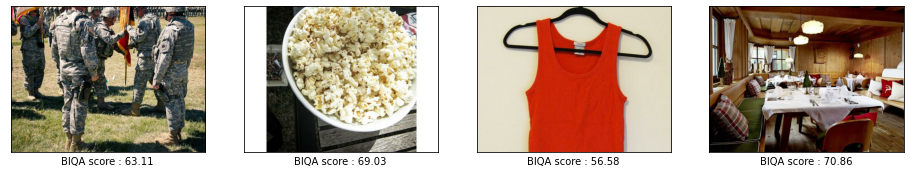

Adversarial images :


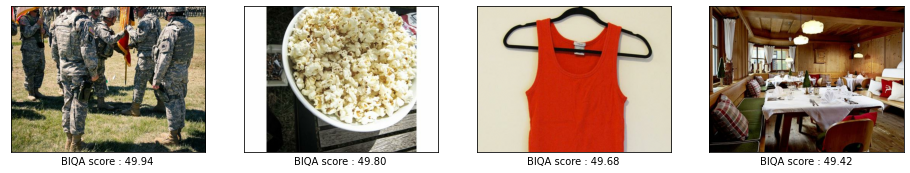

Took 8.0 min 49.63 sec to run 8 samples.

-------------------------------------------------------------------------------------------

Classifier threshold : 30.0



Original images :


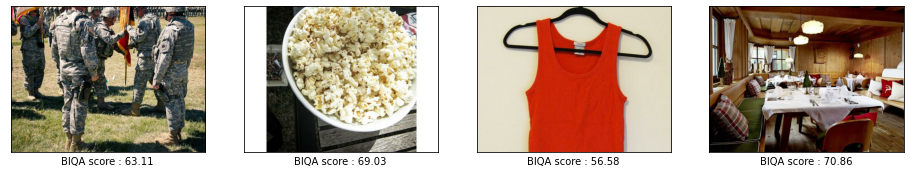

Adversarial images :


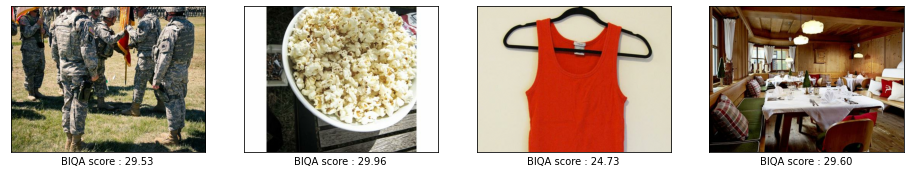

Took 11.0 min 17.75 sec to run 8 samples.

-------------------------------------------------------------------------------------------



In [6]:
from carlini_wagner_l2 import CarliniWagnerL2

BATCH_SIZE = 8
MAX_ITERATIONS = 100
THRESH = [50.0, 30.0]

for thresh in THRESH:
    print("Classifier threshold : {}".format(thresh))
    
    biqa = BiqaClassifier(tf_model, thresh)
    cwl2 = CarliniWagnerL2(biqa, max_iterations=MAX_ITERATIONS)
    cwl2.targeted = True
    dev_class_ds = class_ds(dev_image_ds, thresh).batch(BATCH_SIZE)

    for x, y in dev_class_ds:
        
        time_start = time.time()
        
        target = np.zeros_like(y)
        target[:,1] = 1
        target = tf.cast(target, x.dtype)
        adv_x = cwl2.attack_targeted(x, target)
        
        time_end = time.time()
        
        scores = tf.squeeze(tf_model(input_image=preprocess(x[:4]))[0])
        visualize_result(x, scores, "Original images :")
        
        adv_scores = tf.squeeze(tf_model(input_image=preprocess(adv_x[:4]))[0])
        visualize_result(adv_x, adv_scores, "Adversarial images :")
        
        print("Took {} min {:.2f} sec to run {} samples.".format((time_end-time_start)//60, (time_end-time_start)%60, x.shape[0]))
        
        # remove line below to run the entire dataset
        break
    
    print()
    print("-------------------------------------------------------------------------------------------")
    print()